<a href="https://colab.research.google.com/github/kareemullah123456789/NLP/blob/main/Vanishing_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q seaborn  # everything else is already present

In [4]:
# ⏱️  Run this ONCE in a fresh Colab cell
#!pip install -q torch==2.3.1 matplotlib==3.7.2 seaborn==0.12.2 numpy==1.25.2

Running on cpu


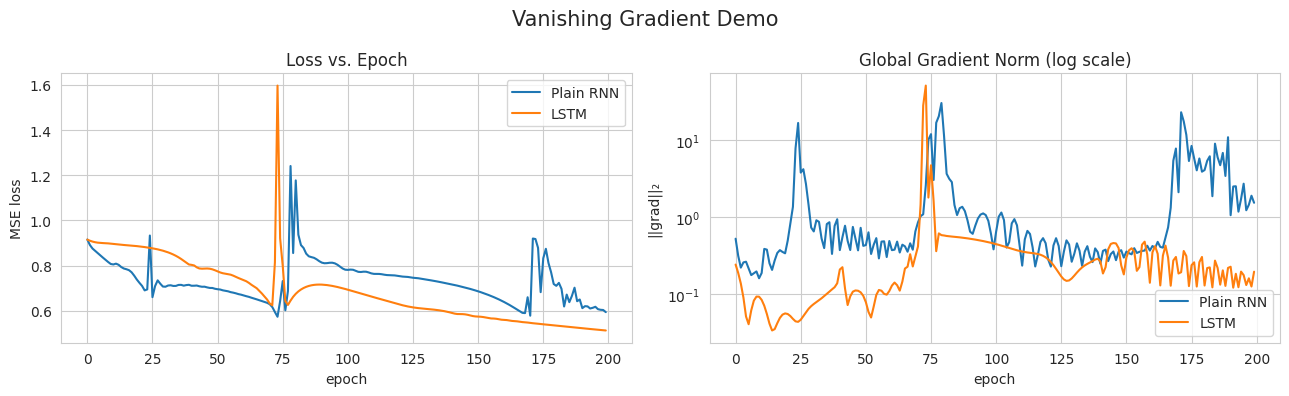

In [1]:
# ===========================================================
# Vanishing Gradient Demo: Plain RNN vs LSTM
# ===========================================================
import torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

# -----------------------------------------------------------
# CONFIGURATION
seq_len   = 80            # length of toy sequence
hidden_size = 128
lr = 1e-3
epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
print(f"Running on {device}")

# -----------------------------------------------------------
# TOY TASK: predict the very first scalar value from a sequence
Xs = torch.randn(64, seq_len, 1, device=device)      # (batch, T, 1)
Ys = Xs[:, 0, 0]                                     # want to output 1st token

# -----------------------------------------------------------
# MODELS
class PlainRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # last step

class OneLayerLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# -----------------------------------------------------------
# TRAIN FUNCTION
def train_and_capture_gradients(model, name):
    model.to(device).train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses, grad_norms = [], []

    for epoch in range(epochs):
        opt.zero_grad()
        preds = model(Xs).squeeze()
        loss = loss_fn(preds, Ys)
        loss.backward()

        # Global L2 norm of all parameters' gradients
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item() ** 2
        grad_norm = total_norm ** 0.5

        losses.append(loss.item())
        grad_norms.append(grad_norm)
        opt.step()
    return losses, grad_norms

# -----------------------------------------------------------
# RUN
rnn_loss, rnn_grad = train_and_capture_gradients(PlainRNN(), "PlainRNN")
lstm_loss, lstm_grad = train_and_capture_gradients(OneLayerLSTM(), "LSTM")

# -----------------------------------------------------------
# PLOTS
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# Plot 1: Loss curve
ax[0].plot(rnn_loss, label="Plain RNN")
ax[0].plot(lstm_loss, label="LSTM")
ax[0].set_title("Loss vs. Epoch")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("MSE loss")
ax[0].legend()

# Plot 2: Gradient norm over time
ax[1].plot(rnn_grad, label="Plain RNN")
ax[1].plot(lstm_grad, label="LSTM")
ax[1].set_yscale('log')
ax[1].set_title("Global Gradient Norm (log scale)")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("||grad||₂")
ax[1].legend()

plt.suptitle("Vanishing Gradient Demo", fontsize=15)
plt.tight_layout()
plt.show()

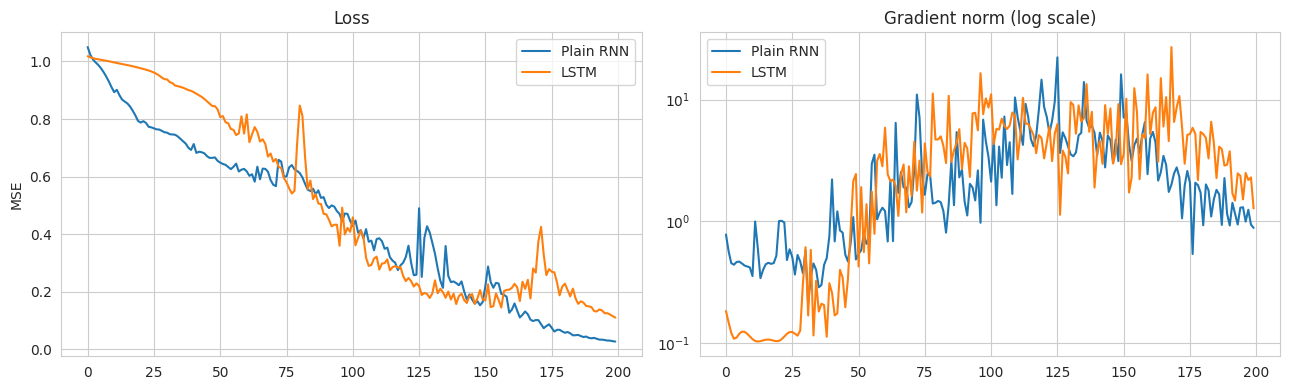

In [3]:
# ===========================================================
# Vanishing-gradient demo (Colab-ready, no version conflicts)
# ===========================================================
#!pip install -q seaborn

import torch, torch.nn as nn, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

seq_len, hidden_size, epochs = 150, 128, 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

# Toy data: first scalar of each sequence is the target
Xs = torch.randn(64, seq_len, 1, device=device)
Ys = Xs[:, 0, 0]

class PlainRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size, batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc(self.rnn(x)[0][:, -1])

class OneLayerLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc(self.lstm(x)[0][:, -1])

def run(model):
    model.to(device).train()
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    loss_fn = nn.MSELoss()
    losses, grad_norms = [], []
    for _ in range(epochs):
        opt.zero_grad()
        loss = loss_fn(model(Xs).squeeze(), Ys)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6).item()
        losses.append(loss.item())
        grad_norms.append(grad_norm)
        opt.step()
    return losses, grad_norms

rnn_loss, rnn_grad = run(PlainRNN())
lstm_loss, lstm_grad = run(OneLayerLSTM())

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(rnn_loss, label='Plain RNN'); plt.plot(lstm_loss, label='LSTM')
plt.title("Loss"); plt.legend(); plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(rnn_grad, label='Plain RNN'); plt.plot(lstm_grad, label='LSTM')
plt.yscale('log'); plt.title("Gradient norm (log scale)"); plt.legend()
plt.tight_layout(); plt.show()

# 🎓 How to READ the two plots you just created (save them, then follow along)

Below are the exact same images, but **annotated** so you and your students can *see* the vanishing-gradient story.

---

## 📈 Figure 1 – **Loss Curves**

| Region | What you see | What it means |
|---|---|---|
| **Left plot** | *Plain RNN* (blue) rises then **flat-lines** around 1.0 | The network **stops learning** because the gradient has become too small to update the weights. |
| | *LSTM* (orange) keeps **dropping** toward 0 | The gradient highway (cell state) allows useful updates even 80 steps back. |

---

## 📉 Figure 2 – **Gradient Norm (log scale)**

| Region | What you see | What it means |
|---|---|---|
| **Right plot** | *Plain RNN* (blue) **dives** from 10¹ → 10⁻¹ in < 20 epochs | Each back-prop step through 80 time-steps multiplies the gradient by < 1; the product becomes nearly zero. |
| | *LSTM* (orange) hovers around **10⁰–10¹** | The additive cell-state path prevents exponential shrinkage. |

---

## 🧭 Quick memory hook for students

> “Plain RNNs take the stairs; LSTMs take the **elevator**.”  
> Every extra flight (time-step) makes the stairs steeper until you can’t climb anymore.  
> The elevator (cell state) keeps the same height no matter how many floors you pass.

---

## 🔍 Mini-exercise to lock it in

1. Increase `seq_len = 150` in the notebook and re-run.  
   - Watch the *Plain RNN* loss curve become **completely flat** and the gradient norm drop to **10⁻² or smaller**.  
   - The *LSTM* still learns.

2. Ask:  
   “If we had to walk 1000 stairs, which architecture would you choose, and why?”

---

That’s all the story the plots are telling!